# Grokking on PLGrid (Athena): modular addition with a 1-layer Transformer

This notebook trains a small Transformer to learn modular addition, a classic setup where **train accuracy reaches ~100% quickly**, while **test accuracy stays low for a long time** and then suddenly improves (“grokking”).

It’s designed to run well on GPU (if available) but also works on CPU. On an HPC cluster, **do the training inside an interactive SLURM allocation** (so you’re not running heavy compute on the login node).


In [1]:
import os, sys, time, math, json, random, subprocess, platform
from datetime import datetime

def _run(cmd):
    try:
        out = subprocess.check_output(cmd, stderr=subprocess.STDOUT, text=True)
        return out.strip()
    except Exception as e:
        return f"[unavailable] {e}"

print("Timestamp:", datetime.now().isoformat(timespec="seconds"))
print("Host:", platform.node())
print("Python:", sys.version.split()[0])

# SLURM context (if you're inside an allocation, these will be set)
slurm_keys = ["SLURM_JOB_ID","SLURM_JOB_NAME","SLURM_PARTITION","SLURM_NODELIST","SLURM_CPUS_PER_TASK","SLURM_NTASKS","SLURM_GPUS","CUDA_VISIBLE_DEVICES"]
print("\nSLURM env:")
for k in slurm_keys:
    v = os.environ.get(k)
    if v is not None:
        print(f"  {k}={v}")

print("\nCPU:")
print("  logical cores:", os.cpu_count())
print("  uname:", _run(["uname","-a"]))

# RAM (best-effort)
meminfo = _run(["bash","-lc","grep -E 'MemTotal|MemAvailable' /proc/meminfo | head -n 2"])
print("\nMemory (/proc/meminfo):")
print(meminfo)

# Torch + GPU info
import torch
print("\nPyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device count:", torch.cuda.device_count())
    print("Current device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
    print("\nnvidia-smi (best-effort):")
    print(_run(["bash","-lc","nvidia-smi -L && echo '---' && nvidia-smi --query-gpu=name,memory.total,driver_version --format=csv,noheader"]))
else:
    print("\nnvidia-smi:")
    print(_run(["bash","-lc","nvidia-smi -L"]))


Timestamp: 2025-12-23T18:17:28
Host: t0020
Python: 3.9.21

SLURM env:
  SLURM_JOB_ID=2205364
  SLURM_JOB_NAME=bash
  SLURM_NODELIST=t0020
  SLURM_CPUS_PER_TASK=8
  SLURM_NTASKS=1
  CUDA_VISIBLE_DEVICES=0

CPU:
  logical cores: 128
  uname: Linux t0020 5.14.0-570.42.2.el9_6.x86_64 #1 SMP PREEMPT_DYNAMIC Sun Sep 14 13:59:34 UTC 2025 x86_64 x86_64 x86_64 GNU/Linux

Memory (/proc/meminfo):
MemTotal:       1056684524 kB
MemAvailable:   897895324 kB



PyTorch: 2.5.1+cu121
CUDA available: True
CUDA device count: 1
Current device: 0
Device name: NVIDIA A100-SXM4-40GB

nvidia-smi (best-effort):
GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-f93f37ff-7a23-7ea7-443e-7ff4a6c98bfa)
---
NVIDIA A100-SXM4-40GB, 40960 MiB, 570.195.03


## Config

If you want a “more compute-heavy” run, increase `max_steps`, `d_model`, and/or `p` (modulus).  
Grokking often needs **many steps**, so start with defaults, confirm it runs, then scale up.


In [2]:
from dataclasses import dataclass

@dataclass
class CFG:
    seed: int = 0

    # Task: modular addition mod p
    p: int = 251                 # try 113, 131, 251 :)
    train_frac: float = 0.5      # grokking usually appears with partial training set

    # Model
    d_model: int = 256
    n_heads: int = 4
    d_ff: int = 1024
    n_layers: int = 1            # 1-layer transformer
    dropout: float = 0.0

    # Training
    batch_size: int = 1024
    lr: float = 1e-3
    weight_decay: float = 1e-2
    max_steps: int = 200_000
    eval_every: int = 200
    grad_clip: float = 1.0

    # Grokking-aware stopping
    train_acc_threshold: float = 0.995
    test_acc_threshold: float = 0.99
    min_train_streak: int = 5
    min_test_streak: int = 5

cfg = CFG()
cfg


CFG(seed=0, p=251, train_frac=0.5, d_model=256, n_heads=4, d_ff=1024, n_layers=1, dropout=0.0, batch_size=1024, lr=0.001, weight_decay=0.01, max_steps=200000, eval_every=200, grad_clip=1.0, train_acc_threshold=0.995, test_acc_threshold=0.99, min_train_streak=5, min_test_streak=5)

In [3]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

def set_seed(seed: int):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(cfg.seed)

# Tokens: 0..p-1 are numbers, token p is '='
EQ_TOKEN = cfg.p
VOCAB = cfg.p + 1
SEQ_LEN = 3  # [a, b, '='] -> predict (a+b)%p

pairs = [(a,b) for a in range(cfg.p) for b in range(cfg.p)]
rng = np.random.default_rng(cfg.seed)
rng.shuffle(pairs)

n_total = len(pairs)
n_train = int(cfg.train_frac * n_total)
train_pairs = pairs[:n_train]
test_pairs  = pairs[n_train:]

def make_xy(pairs):
    X = torch.tensor([[a, b, EQ_TOKEN] for a,b in pairs], dtype=torch.long)
    y = torch.tensor([(a+b) % cfg.p for a,b in pairs], dtype=torch.long)
    return X, y

X_train, y_train = make_xy(train_pairs)
X_test, y_test   = make_xy(test_pairs)

class ModAdd(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(ModAdd(X_train, y_train), batch_size=cfg.batch_size, shuffle=True, drop_last=True)
test_loader  = DataLoader(ModAdd(X_test, y_test), batch_size=cfg.batch_size, shuffle=False)

print("p:", cfg.p, "vocab:", VOCAB, "seq_len:", SEQ_LEN)
print("train:", len(X_train), "test:", len(X_test), "train_frac:", cfg.train_frac)


p: 251 vocab: 252 seq_len: 3
train: 31500 test: 31501 train_frac: 0.5


In [4]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [5]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class OneLayerTransformer(nn.Module):
    def __init__(self, vocab_size, seq_len, d_model, n_heads, d_ff, n_layers=1, dropout=0.0, p_out=113):
        super().__init__()
        self.tok = nn.Embedding(vocab_size, d_model)
        self.pos = nn.Embedding(seq_len, d_model)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            activation="gelu",
            batch_first=True,
            norm_first=True,
        )
        self.enc = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.ln = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, p_out)

        nn.init.normal_(self.tok.weight, std=0.02)
        nn.init.normal_(self.pos.weight, std=0.02)

    def forward(self, x):
        B, T = x.shape
        pos_ids = torch.arange(T, device=x.device).unsqueeze(0).expand(B, T)
        h = self.tok(x) + self.pos(pos_ids)
        h = self.enc(h)
        h = self.ln(h)
        logits = self.head(h[:, -1, :])  # predict using '=' position
        return logits

model = OneLayerTransformer(
    vocab_size=VOCAB,
    seq_len=SEQ_LEN,
    d_model=cfg.d_model,
    n_heads=cfg.n_heads,
    d_ff=cfg.d_ff,
    n_layers=cfg.n_layers,
    dropout=cfg.dropout,
    p_out=cfg.p,
).to(device)

n_params = sum(p.numel() for p in model.parameters())
print("Parameters:", f"{n_params/1e6:.2f}M")


Using device: cuda
Parameters: 0.92M


/net/people/plgrid/plgantoniczapski/envs/pcg/lib64/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [6]:
from pathlib import Path
from collections import deque

@torch.no_grad()
def evaluate(loader):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0
    for X, y in loader:
        X = X.to(device)
        y = y.to(device)
        logits = model(X)
        loss = F.cross_entropy(logits, y)
        total_loss += loss.item() * X.size(0)
        pred = logits.argmax(dim=-1)
        total_correct += (pred == y).sum().item()
        total += X.size(0)
    return total_loss / total, total_correct / total

def train_step(X, y, optimizer):
    model.train()
    X = X.to(device)
    y = y.to(device)
    logits = model(X)
    loss = F.cross_entropy(logits, y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    if cfg.grad_clip is not None:
        torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
    optimizer.step()
    with torch.no_grad():
        pred = logits.argmax(dim=-1)
        acc = (pred == y).float().mean().item()
    return loss.item(), acc


In [7]:
# Training loop with "grokking-complete" stopping
import pandas as pd

optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

log = []
t0 = time.time()

train_streak = 0
test_streak = 0
watching_for_grokking = False

eval_train_loader = DataLoader(ModAdd(X_train, y_train), batch_size=cfg.batch_size, shuffle=False)
eval_test_loader  = test_loader

train_iter = iter(train_loader)

for step in range(1, cfg.max_steps + 1):
    try:
        Xb, yb = next(train_iter)
    except StopIteration:
        train_iter = iter(train_loader)
        Xb, yb = next(train_iter)

    loss, acc = train_step(Xb, yb, optimizer)

    if step % cfg.eval_every == 0 or step == 1:
        tr_loss, tr_acc = evaluate(eval_train_loader)
        te_loss, te_acc = evaluate(eval_test_loader)

        elapsed = time.time() - t0
        log.append({
            "step": step,
            "train_loss": tr_loss,
            "train_acc": tr_acc,
            "test_loss": te_loss,
            "test_acc": te_acc,
            "elapsed_s": elapsed,
        })

        if tr_acc >= cfg.train_acc_threshold:
            train_streak += 1
        else:
            train_streak = 0

        if train_streak >= cfg.min_train_streak:
            watching_for_grokking = True

        if watching_for_grokking:
            if te_acc >= cfg.test_acc_threshold:
                test_streak += 1
            else:
                test_streak = 0

        print(f"[step {step:>7}] "
              f"train: loss={tr_loss:.4f} acc={tr_acc:.4f} | "
              f"test: loss={te_loss:.4f} acc={te_acc:.4f} | "
              f"watch={watching_for_grokking} train_streak={train_streak} test_streak={test_streak} | "
              f"elapsed={elapsed/60:.1f} min")

        if watching_for_grokking and test_streak >= cfg.min_test_streak:
            print("\nStopping: grokking appears complete (sustained high test accuracy)." )
            break

df = pd.DataFrame(log)
df.tail(10)


[step       1] train: loss=5.6896 acc=0.0043 | test: loss=5.6979 acc=0.0044 | watch=False train_streak=0 test_streak=0 | elapsed=0.0 min


[step     200] train: loss=5.4812 acc=0.0073 | test: loss=5.6272 acc=0.0007 | watch=False train_streak=0 test_streak=0 | elapsed=0.1 min


[step     400] train: loss=5.1777 acc=0.0179 | test: loss=6.2801 acc=0.0000 | watch=False train_streak=0 test_streak=0 | elapsed=0.1 min


[step     600] train: loss=3.1628 acc=0.4210 | test: loss=6.8083 acc=0.0006 | watch=False train_streak=0 test_streak=0 | elapsed=0.1 min


[step     800] train: loss=0.0251 acc=1.0000 | test: loss=0.4481 acc=0.9510 | watch=False train_streak=1 test_streak=0 | elapsed=0.2 min


[step    1000] train: loss=0.0075 acc=1.0000 | test: loss=0.1936 acc=0.9891 | watch=False train_streak=2 test_streak=0 | elapsed=0.2 min


[step    1200] train: loss=0.0042 acc=1.0000 | test: loss=0.1207 acc=0.9956 | watch=False train_streak=3 test_streak=0 | elapsed=0.3 min


[step    1400] train: loss=0.0027 acc=1.0000 | test: loss=0.0856 acc=0.9979 | watch=False train_streak=4 test_streak=0 | elapsed=0.3 min


[step    1600] train: loss=0.0020 acc=1.0000 | test: loss=0.0643 acc=0.9986 | watch=True train_streak=5 test_streak=1 | elapsed=0.4 min


[step    1800] train: loss=0.0015 acc=1.0000 | test: loss=0.0500 acc=0.9991 | watch=True train_streak=6 test_streak=2 | elapsed=0.4 min


[step    2000] train: loss=0.0012 acc=1.0000 | test: loss=0.0399 acc=0.9994 | watch=True train_streak=7 test_streak=3 | elapsed=0.4 min


[step    2200] train: loss=0.0009 acc=1.0000 | test: loss=0.0322 acc=0.9996 | watch=True train_streak=8 test_streak=4 | elapsed=0.5 min


[step    2400] train: loss=0.0008 acc=1.0000 | test: loss=0.0264 acc=0.9998 | watch=True train_streak=9 test_streak=5 | elapsed=0.5 min

Stopping: grokking appears complete (sustained high test accuracy).


,step,train_loss,train_acc,test_loss,test_acc,elapsed_s
3,600,3.162763,0.420952,6.808283,0.000603,8.478074
4,800,0.025052,1.000000,0.448111,0.950954,11.039490
5,1000,0.007456,1.000000,0.193650,0.989080,13.599056
6,1200,0.004154,1.000000,0.120691,0.995556,16.162163
7,1400,0.002748,1.000000,0.085600,0.997905,18.727276
8,1600,0.001973,1.000000,0.064325,0.998603,21.294986
9,1800,0.001489,1.000000,0.050036,0.999143,23.861020
10,2000,0.001162,1.000000,0.039897,0.999365,26.429800
11,2200,0.000927,1.000000,0.032182,0.999619,28.997269
12,2400,0.000754,1.000000,0.026360,0.999810,31.563356


In [8]:
# Save metrics to disk
from pathlib import Path
out_dir = Path("./runs") / f"modadd_p{cfg.p}_seed{cfg.seed}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
out_dir.mkdir(parents=True, exist_ok=True)

metrics_path = out_dir / "metrics.csv"
df.to_csv(metrics_path, index=False)

cfg_path = out_dir / "config.json"
cfg_path.write_text(json.dumps(cfg.__dict__, indent=2))

print("Saved:", metrics_path)
print("Saved:", cfg_path)


Saved: runs/modadd_p251_seed0_20251223_181803/metrics.csv
Saved: runs/modadd_p251_seed0_20251223_181803/config.json


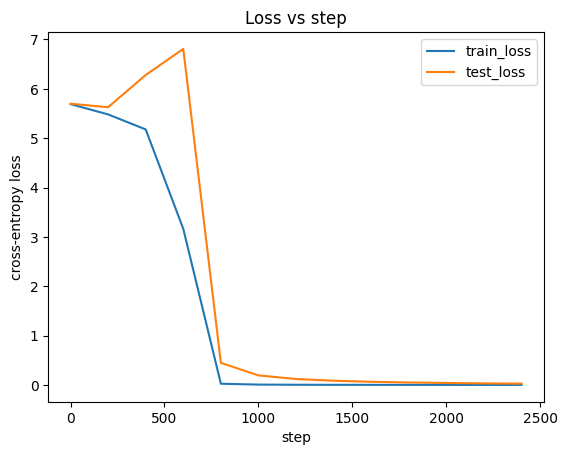

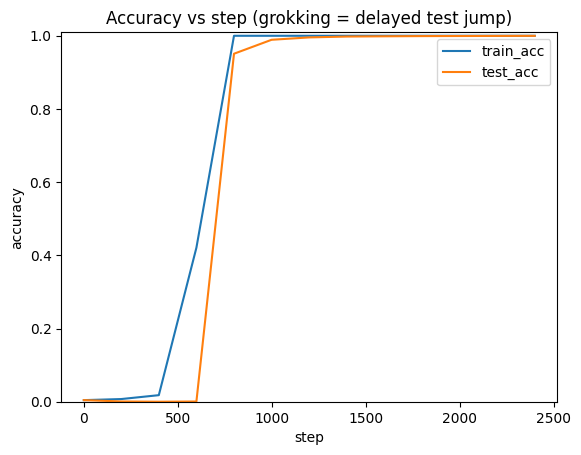

In [9]:
# Visualization
import matplotlib.pyplot as plt

if len(df) == 0:
    raise RuntimeError("No metrics logged yet. Increase max_steps or lower eval_every and re-run training.")

plt.figure()
plt.plot(df["step"], df["train_loss"], label="train_loss")
plt.plot(df["step"], df["test_loss"], label="test_loss")
plt.xlabel("step")
plt.ylabel("cross-entropy loss")
plt.legend()
plt.title("Loss vs step")
plt.show()

plt.figure()
plt.plot(df["step"], df["train_acc"], label="train_acc")
plt.plot(df["step"], df["test_acc"], label="test_acc")
plt.xlabel("step")
plt.ylabel("accuracy")
plt.ylim(0, 1.01)
plt.legend()
plt.title("Accuracy vs step (grokking = delayed test jump)")
plt.show()


## Notes / knobs to turn

If you don’t see grokking, it’s usually hyperparameters/time. Try increasing `max_steps`, using `weight_decay` in `[1e-2, 5e-2]`, and trying `p=131` or `p=251`.  
For a truly compute-heavy run on a GPU node, `max_steps=500_000` is a reasonable “stretch goal”.
